Начальные стратегии игроков: ['Маневрировать', 'Защищаться', 'Маневрировать']

Раунд 1:
Игрок 1 выбрал 'Маневрировать', выплата: -1.288328097224645
Игрок 2 выбрал 'Защищаться', выплата: 1.8440033154715159
Игрок 3 выбрал 'Маневрировать', выплата: 1.6897865734337212

Раунд 2:
Игрок 1 выбрал 'Атаковать', выплата: 3.0616388634141822
Игрок 2 выбрал 'Атаковать', выплата: 3.0300656110702526
Игрок 3 выбрал 'Атаковать', выплата: 5.258865169734131

Раунд 3:
Игрок 1 выбрал 'Атаковать', выплата: -4.388276399383447
Игрок 2 выбрал 'Защищаться', выплата: -3.6861007571167526
Игрок 3 выбрал 'Атаковать', выплата: 3.6970701698366457

Раунд 4:
Игрок 1 выбрал 'Атаковать', выплата: 2.6303540653362223
Игрок 2 выбрал 'Атаковать', выплата: 4.706622582342521
Игрок 3 выбрал 'Защищаться', выплата: 1.7717988993970526

Раунд 5:
Игрок 1 выбрал 'Переговоры', выплата: 1.8295071587123726
Игрок 2 выбрал 'Отступить', выплата: 4.473760902383381
Игрок 3 выбрал 'Отступить', выплата: 4.6848116632637735

Раунд 6:
Игрок 1 выбр

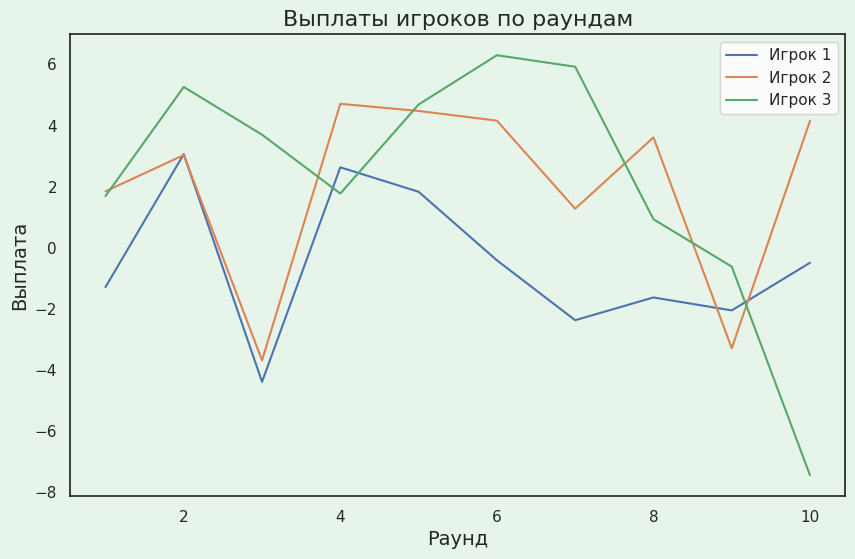

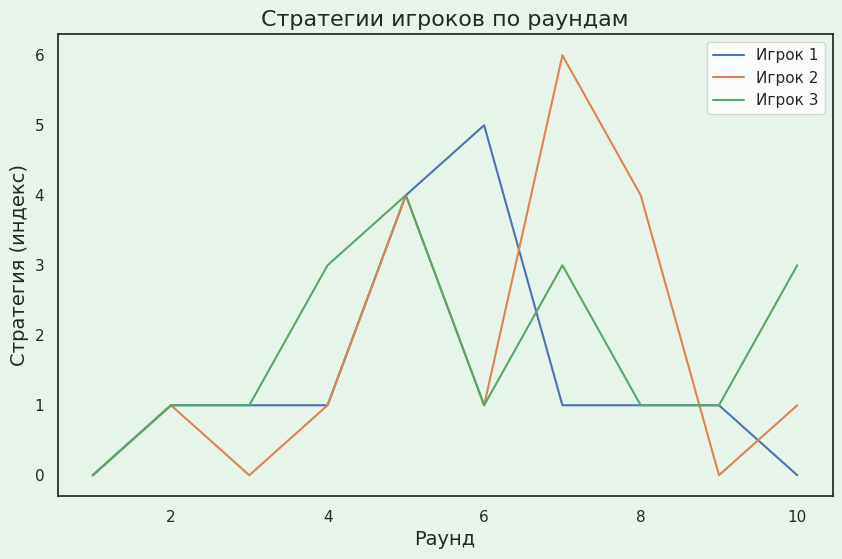


Итоговые стратегии после всех раундов:
Игрок 1: Маневрировать
Игрок 2: Отступить
Игрок 3: Маневрировать


In [3]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Определение стратегий
strategies = ["Атаковать", "Защищаться", "Отступить", "Маневрировать", "Переговоры"]
num_strategies = len(strategies)

# Определение числа игроков и начальных альянсов
num_players = 3
alliances = {0: [1], 1: [0], 2: []}  # Игроки 0 и 1 в альянсе
break_threshold = -5  # Порог, при котором альянс разрушается

# Параметры Q-обучения
learning_rate = 0.1
gamma = 0.9  # Коэффициент дисконтирования
epsilon = 0.2  # Эпсилон для эпсилон-жадной стратегии
num_rounds = 10

# Определение типов игроков
player_types = ["агрессивный", "осторожный", "сбалансированный"]

# Инициализация Q-таблиц для каждого игрока
Q_tables = [np.zeros((num_strategies, num_strategies)) for _ in range(num_players)]

# Для визуализации
payoffs_history = {i: [] for i in range(num_players)}
strategies_history = {i: [] for i in range(num_players)}

# Функция для получения динамической матрицы выплат с учетом внешних факторов
def get_dynamic_payoff_matrix(round_num):
    seasonal_effect = np.sin(round_num / 3.0)
    random_effect = np.random.normal(0, 1, (num_strategies, num_strategies))
    return np.random.randint(-5, 6, size=(num_strategies, num_strategies)) + seasonal_effect + random_effect

# Функция для пересмотра альянсов
def update_alliances(round_num, payoffs):
    for i in range(num_players):
        if alliances[i]:
            total_alliance_payoff = sum(payoffs[j] for j in alliances[i])
            if total_alliance_payoff < break_threshold:
                for ally in alliances[i]:
                    alliances[ally].remove(i)
                alliances[i] = []

# Начальные стратегии игроков
current_strategies = [random.choice(strategies) for _ in range(num_players)]
print(f"Начальные стратегии игроков: {current_strategies}")

# Проведение нескольких раундов конфликта
for round_num in range(1, num_rounds + 1):
    print(f"\nРаунд {round_num}:")

    payoff_matrices = [get_dynamic_payoff_matrix(round_num) for _ in range(num_players)]
    strategy_indices = [strategies.index(strategy) for strategy in current_strategies]

    payoffs = [
        payoff_matrices[player_idx][strategy_indices[player_idx], strategy_indices[(player_idx + 1) % num_players]]
        for player_idx in range(num_players)
    ]

    for i in range(num_players):
        print(f"Игрок {i+1} выбрал '{current_strategies[i]}', выплата: {payoffs[i]}")
        payoffs_history[i].append(payoffs[i])
        strategies_history[i].append(current_strategies[i])

    for i in range(num_players):
        current_state = strategy_indices[i]
        opponent_state = strategy_indices[(i + 1) % num_players]
        reward = payoffs[i]

        if alliances[i]:
            alliance_reward = sum(payoffs[j] for j in alliances[i])
            reward += alliance_reward * 0.5

        future_q = np.max(Q_tables[i][opponent_state])
        Q_tables[i][current_state, opponent_state] = Q_tables[i][current_state, opponent_state] + \
            learning_rate * (reward + gamma * future_q - Q_tables[i][current_state, opponent_state])

    for i in range(num_players):
        if random.uniform(0, 1) < epsilon:
            current_strategies[i] = random.choice(strategies)
        else:
            q_values = Q_tables[i][strategy_indices[i]]
            if player_types[i] == "агрессивный":
                best_strategy_idx = np.argmax(q_values)
            elif player_types[i] == "осторожный":
                best_strategy_idx = np.argmin(q_values)
            else:
                best_strategy_idx = np.argmax(q_values) if random.random() > 0.5 else np.argmin(q_values)
            current_strategies[i] = strategies[best_strategy_idx]

    update_alliances(round_num, payoffs)

# Визуализация с использованием Seaborn
sns.set(style="white")  # Убираем сетку

# Настройка фона графика
def set_background_color(ax, color):
    ax.set_facecolor(color)
    ax.figure.set_facecolor(color)

# Визуализация выплат
plt.figure(figsize=(10, 6))
for player, payoffs in payoffs_history.items():
    sns.lineplot(x=range(1, num_rounds + 1), y=payoffs, label=f"Игрок {player + 1}")
plt.title('Выплаты игроков по раундам', fontsize=16)
plt.xlabel('Раунд', fontsize=14)
plt.ylabel('Выплата', fontsize=14)
plt.legend()

# Изменение фона графика на светло-зеленый
ax = plt.gca()
set_background_color(ax, '#E6F4EA')
plt.show()

# Визуализация стратегий
plt.figure(figsize=(10, 6))
for player, strategies in strategies_history.items():
    sns.lineplot(x=range(1, num_rounds + 1), y=[strategies.index(s) for s in strategies], label=f"Игрок {player + 1}")
plt.title('Стратегии игроков по раундам', fontsize=16)
plt.xlabel('Раунд', fontsize=14)
plt.ylabel('Стратегия (индекс)', fontsize=14)
plt.legend()

# Изменение фона графика на светло-зеленый
ax = plt.gca()
set_background_color(ax, '#E6F4EA')
plt.show()

# Итоговые стратегии после всех раундов
print("\nИтоговые стратегии после всех раундов:")
for i in range(num_players):
    print(f"Игрок {i+1}: {current_strategies[i]}")
